In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.image as imd

import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
train_path = '/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/train/images'
valid_path = '/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/valid/images'

In [7]:
def extract_from_path(path)-> []:
    full_path = []
    for i in sorted(os.listdir(path)):
        full_path.append(os.path.join(path, i))
    return full_path

In [8]:
train_images = extract_from_path(train_path)
valid_images = extract_from_path(valid_path)

print(f"The length of train_images is {len(train_images)}")
print(f"The length of valid_images is {len(valid_images)}")

The length of train_images is 5059
The length of valid_images is 302


In [9]:
def createDataFrame(image_paths):
    labels = [path.split('/')[-1].split('_')[0] for path in image_paths]
    df = pd.DataFrame({'path': image_paths, 'label': labels})
    df['label_id'] = df['label'].apply(lambda x: 1 if x == 'smoking' else 0)
    return df

In [10]:
train_images_df = createDataFrame(train_images)
valid_images_df = createDataFrame(valid_images)

In [12]:
def plotCount(df):
    name = df["path"][0].split("/")[4]
    smoking = df[df['label_id'] == 1]    
    print(f"Total images in {name} is {len(df)}")
    print(f"Total smoking images is {len(smoking)}")
    print(f"Total non-smoking images is {len(df)-len(smoking)}")
    sns.set_style("whitegrid")
    sns.countplot(x='label_id', data=df)

Total images in Smooking Detection.v4i.yolov8 is 5059
Total smoking images is 1387
Total non-smoking images is 3672


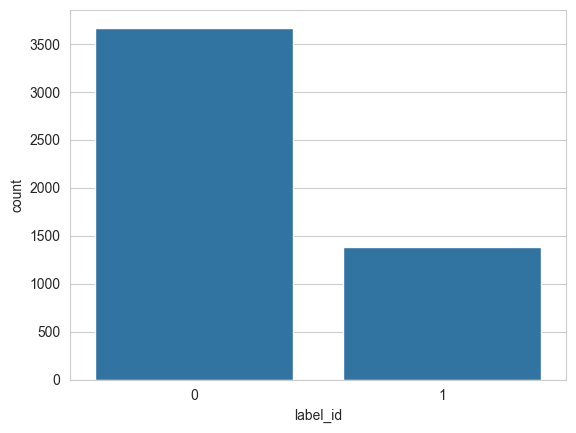

In [13]:
plotCount(train_images_df)

Total images in Smooking Detection.v4i.yolov8 is 302
Total smoking images is 82
Total non-smoking images is 220


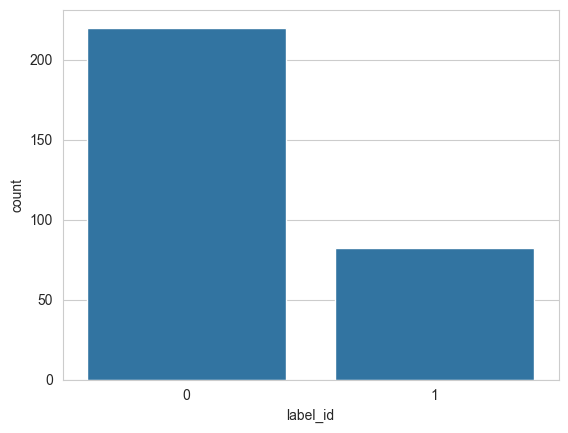

In [14]:
plotCount(valid_images_df)

In [15]:
train_images_df

,path,label,label_id
0,/Users/didaryilmaz/Downloads/Smooking Detectio...,01F7SPZHIVLR,0
1,/Users/didaryilmaz/Downloads/Smooking Detectio...,01F7SPZHIVLR,0
2,/Users/didaryilmaz/Downloads/Smooking Detectio...,01F7SPZHIVLR,0
3,/Users/didaryilmaz/Downloads/Smooking Detectio...,05G13BWZVLKE,0
4,/Users/didaryilmaz/Downloads/Smooking Detectio...,05G13BWZVLKE,0
...,...,...,...
5054,/Users/didaryilmaz/Downloads/Smooking Detectio...,smoking,1
5055,/Users/didaryilmaz/Downloads/Smooking Detectio...,smoking,1
5056,/Users/didaryilmaz/Downloads/Smooking Detectio...,smoking,1
5057,/Users/didaryilmaz/Downloads/Smooking Detectio...,smoking,1


In [16]:
import tensorflow as tf

IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

def imgPreProcessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMAGE_SIZE))
    return img, label
def loadDataset(df:pd.DataFrame):
    dataset = tf.data.Dataset.from_tensor_slices((df['path'], df['label_id']))
    return (dataset
                 .map(imgPreProcessing)
                .shuffle(BATCH_SIZE * 20)
                 .batch(BATCH_SIZE))

In [17]:
train_data = loadDataset(train_images_df)
valid_data = loadDataset(valid_images_df)

In [18]:
# Visualize some random images from the training data

def plotRandom(data):
    for img,label in data.take(1):
        randomNum = random.randint(0, BATCH_SIZE - 1)
        text_label = "Smoking" if label[randomNum].numpy() == 1 else "Non-Smoking"
        plt.figure(figsize=(4, 4))
        plt.imshow(img[randomNum]/255.)
        plt.title(text_label)
        plt.axis('off') 
        plt.show()

In [34]:
def create_b0_base(lr:float = 0.001)->tf.keras.Model:
    model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    model.trainable = False
    
    input_ = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name = "input layer")
    x = model(input_)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    output = tf.keras.layers.Dense(2,activation = "sigmoid")(x)
    
    base_model = tf.keras.Model(input_,output)
    base_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = lr), metrics = ["accuracy"])
    return base_model

In [35]:
def plot_history(model_history):
    plt.style.use("seaborn-v0_8-whitegrid")
    df = pd.DataFrame(model_history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    loss = df['loss']
    accuracy = df['accuracy']
    val_loss = df['val_loss']
    val_accuracy = df['val_accuracy']
    epochs = range(len(df['val_loss']))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_title("Loss")
    
    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    ax2.set_title("Accuracy")
    
    # Adjust spacing and titles
    plt.tight_layout()
    plt.show()

In [1]:
# Gerekli kütüphaneleri yükle
import os
import shutil

# Dataset yolları
data_dir = "/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8"
train_images_dir = os.path.join(data_dir, "train/images")
train_labels_dir = os.path.join(data_dir, "train/labels")
valid_images_dir = os.path.join(data_dir, "valid/images")
valid_labels_dir = os.path.join(data_dir, "valid/labels")
data_yaml = os.path.join(data_dir, "data.yaml")

def dataset_location():
    return data_dir

# Dataset kontrolü
if not all([os.path.exists(train_images_dir), os.path.exists(train_labels_dir), 
            os.path.exists(valid_images_dir), os.path.exists(valid_labels_dir), os.path.exists(data_yaml)]):
    raise FileNotFoundError("Dataset dosyaları eksik veya yanlış bir yapıda.")

print("Dataset yapısı doğru ve kullanıma hazır.")

# YOLOv8 ile eğitim yapmak için terminalde çalıştırılacak komutları hazırlayın
def generate_yolov8_command():
    train_command = (
        f"yolo task=detect mode=train epochs=50 batch=16 plots=True "
        f"model=yolov8n.pt data={data_yaml} imgsz=640"
    )
    return train_command

# YOLOv8 komutunu yazdır
train_command = generate_yolov8_command()
print(train_command)


Dataset yapısı doğru ve kullanıma hazır.
yolo task=detect mode=train epochs=50 batch=16 plots=True model=yolov8n.pt data=/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/data.yaml imgsz=640


In [5]:
from ultralytics import YOLO

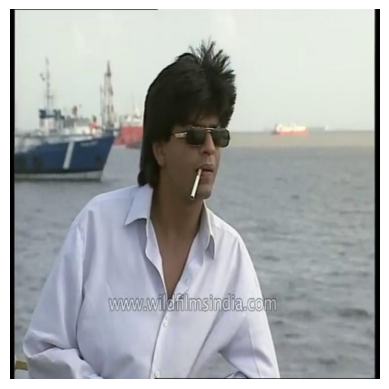

In [6]:
import os
import matplotlib.pyplot as plt
import cv2  # or any other image reading library you prefer

# Define the path to the image folder
image_path = '/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/valid/images'

# Get the list of all image files in the directory
image_files = os.listdir(image_path)

# Iterate over the image files and display the first image
for i, image_file in enumerate(image_files):
    image = cv2.imread(f'{image_path}/{image_file}')  # Reading the image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB for proper display

    plt.imshow(image)
    plt.axis('off')  # Hide the axes for a cleaner display
    plt.show()

    break  # Display only the first image


In [11]:
import os
from pathlib import Path

# Define the path to the dataset location
dataset_location = '/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8'

# Construct the full path to the data.yaml file
data_yaml_path = os.path.join(dataset_location, 'data.yaml')

# YOLOv8 training command (using subprocess to run shell commands in Python)
import subprocess

# Construct the command to run YOLOv8 training
command = [
    'yolo', 
    'task=detect', 
    'mode=train', 
    'epochs=30', 
    'batch=8', 
    'plots=True', 
    f'model=yolov8n.pt',  # Nano model daha hızlıdır
    f'data={data_yaml_path}', 
    'imgsz=416'
]



# Run the training command using subprocess
subprocess.run(command)


New https://pypi.org/project/ultralytics/8.3.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.49 🚀 Python-3.9.21 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/data.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

train: Scanning /Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/train/labels.cache... 5059 images, 3 backgrounds, 0 corrupt: 100%|██████████| 5059/5059 [00:00<?, ?it/s]
val: Scanning /Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/valid/labels.cache... 302 images, 0 backgrounds, 0 corrupt: 100%|██████████| 302/302 [00:00<?, ?it/s]


Plotting labels to /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.257      2.566      1.596          4        416: 100%|██████████| 633/633 [05:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


                   all        302        316      0.547      0.474      0.451      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      2.266      2.026      1.643          6        416: 100%|██████████| 633/633 [12:23<00:00,  1.17s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.636      0.516      0.533      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      2.251      1.887      1.639          3        416: 100%|██████████| 633/633 [05:32<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.579      0.553      0.528      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      2.193      1.804      1.606          7        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316        0.6      0.603      0.593      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      2.142      1.708      1.575          6        416: 100%|██████████| 633/633 [05:29<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.632      0.642      0.583      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      2.107      1.613      1.546          4        416: 100%|██████████| 633/633 [05:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.677      0.611      0.662      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      2.073      1.545      1.541          3        416: 100%|██████████| 633/633 [05:36<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.747      0.658      0.702      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G       2.02       1.48      1.493          3        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.775      0.693      0.744      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G       2.01      1.395      1.486          4        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:22<00:00,  1.17s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.757      0.693      0.756      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.995      1.373      1.474          4        416: 100%|██████████| 633/633 [05:30<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.769      0.734      0.758      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.959        1.3      1.445          0        416: 100%|██████████| 633/633 [05:34<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.821      0.734      0.787      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.934      1.285      1.426          3        416: 100%|██████████| 633/633 [05:36<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316       0.83      0.715      0.815      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.919      1.257      1.427          4        416: 100%|██████████| 633/633 [05:32<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.802      0.741      0.785      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G        1.9      1.229      1.408          3        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.849      0.715        0.8      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.865      1.173      1.396          6        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316       0.81      0.754      0.806       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.864      1.183      1.394          7        416: 100%|██████████| 633/633 [05:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316       0.82      0.762      0.827       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.837      1.144      1.378          3        416: 100%|██████████| 633/633 [05:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:22<00:00,  1.16s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.842       0.76      0.822      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.798      1.094      1.363          2        416: 100%|██████████| 633/633 [05:31<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.836       0.81      0.846      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.793      1.076       1.36          9        416: 100%|██████████| 633/633 [05:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.853      0.771      0.839      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.773       1.05      1.343          4        416: 100%|██████████| 633/633 [05:25<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.895      0.755      0.856      0.367
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.725     0.8862      1.377          3        416: 100%|██████████| 633/633 [05:20<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.818      0.795      0.854      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.676     0.8375       1.35          2        416: 100%|██████████| 633/633 [05:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.853      0.771      0.853       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.671     0.8184      1.346          3        416: 100%|██████████| 633/633 [05:26<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:22<00:00,  1.16s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.867      0.785       0.85      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.623     0.8088      1.318          4        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.855      0.801      0.862      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G       1.59     0.7709      1.301          3        416: 100%|██████████| 633/633 [05:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.809       0.82      0.853      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.567     0.7567      1.286          3        416: 100%|██████████| 633/633 [05:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.837      0.816       0.86      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.553     0.7351      1.273          3        416: 100%|██████████| 633/633 [05:27<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.835      0.858      0.859      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.516     0.7196      1.256          3        416: 100%|██████████| 633/633 [05:28<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.876      0.804      0.879       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.491      0.709      1.244          3        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:21<00:00,  1.14s/it]
  0%|          | 0/633 [00:00<?, ?it/s]

                   all        302        316      0.832      0.817      0.865      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.463     0.6913      1.227          3        416: 100%|██████████| 633/633 [05:24<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:36<00:00,  1.90s/it]


                   all        302        316      0.822      0.832      0.872      0.381

30 epochs completed in 3.038 hours.
Optimizer stripped from /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/weights/last.pt, 6.2MB
Optimizer stripped from /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/weights/best.pt, 6.2MB

Validating /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.9.21 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [01:01<00:00,  3.22s/it]


                   all        302        316      0.835      0.858      0.859      0.384
Speed: 0.8ms preprocess, 187.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /Users/didaryilmaz/Documents/GitHub/WeaponDetector/data/dataset/detect/train15
💡 Learn more at https://docs.ultralytics.com/modes/train


CompletedProcess(args=['yolo', 'task=detect', 'mode=train', 'epochs=30', 'batch=8', 'plots=True', 'model=yolov8n.pt', 'data=/Users/didaryilmaz/Downloads/Smooking Detection.v4i.yolov8/data.yaml', 'imgsz=416'], returncode=0)

In [1]:
from ultralytics import YOLO
import cv2

# Load the model
model = YOLO('best.onnx')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break  

    # Perform detection
    results = model(frame)
    result = results[0]

    # Annotate and display the frame
    annotated_frame = result.plot() 
    cv2.imshow('YOLO Inference', annotated_frame)
    
    if cv2.waitKey(1) == 27:  # Press 'ESC' to exit
        break

cap.release()
cv2.destroyAllWindows()

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnx'] not found, attempting AutoUpdate...
Retry 1/2 failed: Command 'pip install --no-cache-dir "onnx" ' returned non-zero exit status 126.


/bin/sh: /Users/didaryilmaz/Documents/GitHub/Smoking_Detection/myenvd/bin/pip: /Users/didaryilmaz/Documents/GitHub/WeaponDetector/myenvd/bin/python3.9: bad interpreter: No such file or directory


Retry 2/2 failed: Command 'pip install --no-cache-dir "onnx" ' returned non-zero exit status 126.
requirements: ❌ Command 'pip install --no-cache-dir "onnx" ' returned non-zero exit status 126.
Preferring ONNX Runtime CoreMLExecutionProvider



/bin/sh: /Users/didaryilmaz/Documents/GitHub/Smoking_Detection/myenvd/bin/pip: /Users/didaryilmaz/Documents/GitHub/WeaponDetector/myenvd/bin/python3.9: bad interpreter: No such file or directory
2025-01-01 13:56:42.815576 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 11 number of nodes in the graph: 233 number of nodes supported by CoreML: 221


0: 640x640 (no detections), 20.9ms
Speed: 5.0ms preprocess, 20.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.0ms
Speed: 3.6ms preprocess, 17.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 1.6ms preprocess, 10.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.7ms
Speed: 1.7ms preprocess, 10.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 10.5ms
Speed: 1.9ms preprocess, 10.5ms infe

KeyboardInterrupt: 

: 